<a href="https://colab.research.google.com/github/SubhrajyotiGoswami226/IITGDeepLearningAssignment/blob/master/Qno1pytorchIITG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00


In [3]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)


Using cpu


In [5]:
# 1.1  Transforms: convert to tensor & flatten (for MLP) or keep 1×28×28 (for CNN)
common_tf = transforms.Compose([
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # mean & std of MNIST
])

train_ds = datasets.MNIST(root=Path.home()/"data",
                          train=True, download=True, transform=common_tf)
test_ds  = datasets.MNIST(root=Path.home()/"data",
                          train=False, download=True, transform=common_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1000)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.74MB/s]


In [6]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        correct  += pred.argmax(1).eq(y).sum().item()
        total    += x.size(0)

    return loss_sum/total, correct/total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)

        loss_sum += loss.item() * x.size(0)
        correct  += pred.argmax(1).eq(y).sum().item()
        total    += x.size(0)

    return loss_sum/total, correct/total


In [7]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),              # 28×28 → 784
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)         # logits for 10 classes
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP().to(device)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

EPOCHS = 5
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(mlp, train_loader, criterion, optimizer)
    te_loss, te_acc = evaluate(mlp, test_loader, criterion)
    print(f"Epoch {ep}: "
          f"train acc {tr_acc:.4f}  test acc {te_acc:.4f}")


Epoch 1: train acc 0.9293  test acc 0.9667
Epoch 2: train acc 0.9701  test acc 0.9723
Epoch 3: train acc 0.9798  test acc 0.9737
Epoch 4: train acc 0.9841  test acc 0.9686
Epoch 5: train acc 0.9869  test acc 0.9796


In [9]:
mlp_test_loss, mlp_test_acc = evaluate(mlp, test_loader, criterion)
print(f"✅ MLP Test Accuracy: {mlp_test_acc * 100:.2f}%")


✅ MLP Test Accuracy: 97.96%


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 32×14×14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 64×7×7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                   # 64·7·7 = 3136
            nn.Linear(3136, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.feature(x)
        return self.classifier(x)

cnn = SimpleCNN().to(device)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

EPOCHS = 5
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(cnn, train_loader, criterion, optimizer)
    te_loss, te_acc = evaluate(cnn, test_loader, criterion)
    print(f"Epoch {ep}: "
          f"train acc {tr_acc:.4f}  test acc {te_acc:.4f}")


Epoch 1: train acc 0.9461  test acc 0.9872
Epoch 2: train acc 0.9809  test acc 0.9902
Epoch 3: train acc 0.9865  test acc 0.9914
Epoch 4: train acc 0.9887  test acc 0.9875
Epoch 5: train acc 0.9906  test acc 0.9929


In [12]:
cnn_test_loss, cnn_test_acc = evaluate(cnn, test_loader, criterion)
print(f"✅ CNN Test Accuracy: {cnn_test_acc * 100:.2f}%")


✅ CNN Test Accuracy: 99.29%


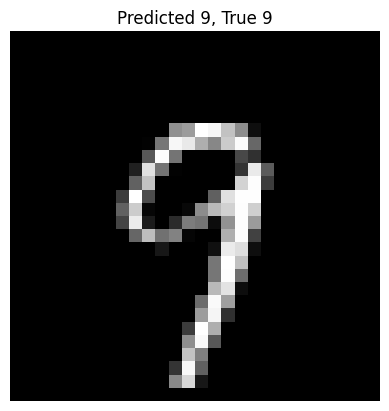

In [15]:
import random
cnn.eval()
imgs, labels = next(iter(test_loader))
idx = random.randrange(len(imgs))
img = imgs[idx].unsqueeze(0).to(device)

with torch.no_grad():
    pred = cnn(img).argmax(1).item()

plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.title(f"Predicted {pred}, True {labels[idx].item()}")
plt.axis("off")
plt.show()
